This exploring notebook serves to get a better intuition of how the parameters passed to `pycbc.waveform.get_td_waveform`, namely `sample_rate`, `f_lower`, and `mass1` and `mass2` affect the generated waveforms.

In [37]:
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def gen_data_strain(config):
    hp, hc = get_td_waveform(
        approximant=config["approximant"],
        mass1=config["mass1"],
        mass2=config["mass2"],
        distance=config["distance"],
        inclination=config["inclination"],
        f_lower=config["freq_lower"],
        delta_t=1.0 / config["sample_rate"],
    )
    return hp, hc

In [23]:
config = {
    'approximant': "IMRPhenomPv2",
    'mass1': 2.0,
    'mass2': 2.0,
    'distance': 100,
    'inclination': 0.0,
    'sample_rate': 1024,
    'freq_lower': None
}

Here, we compare different masses.

In [5]:
config['mass1'], config['mass2'] = 2.0, 2.0
config['sample_rate'] = 1024 * 8
config['freq_lower'] = 100
hp1, _ = gen_data_strain(config)

In [6]:
config['mass1'], config['mass2'] = 1.0, 1.0
config['sample_rate'] = 1024 * 8
config['freq_lower'] = 100
hp2, _ = gen_data_strain(config)

In [7]:
len(hp1), len(hp2)

(32768, 131072)

Waveforms from lower masses are longer in duration.  
We want to optimize the `f_lower` parameter, that is, increase it to speed up waveform generation. 
The worst case, i.e., where we risk not having enough samples fo fill our desired window, is when we consider the higher masses.

**Conclusion:** for lower masses, we can increase the `f_lower` frequency.

Now we test a different sample rate, also using the maximum and minimum masses.

In [8]:
config['mass1'], config['mass2'] = 2.0, 2.0
config['sample_rate'] = 1024
config['freq_lower'] = 100
hp3, _ = gen_data_strain(config)

In [11]:
config['mass1'], config['mass2'] = 1.0, 1.0
config['sample_rate'] = 1024
config['freq_lower'] = 100
hp4, _ = gen_data_strain(config)

In [12]:
len(hp3), len(hp4)

(4096, 16384)

In [14]:
len(hp1) / len(hp3)

8.0

The length of a waveform with 8 times the sample rate (all other variables constant) is 8 times higher.

In [108]:
for hp in (hp1, hp2, hp3, hp4):
    print(hp.sample_times[0], np.round(hp.sample_times[-1], 2))

-3.8 0.2
-15.8 0.2
-3.8 0.2
-15.8 0.2


_Note:_ -3.8 means 3.8 seconds before merger. 0.2 means 0.2 seconds after merger.  

We can see that we are starting the simulation way too soon, as we have, respectively, 4 seconds and 16 seconds of data, for the higher and lower masses.  
Waveforms with the same mass but different sample rates start and end at the same time.

Now, let's test different `f_lower` values.

In [124]:
config['sample_rate'] = 1024
freqs = np.linspace(10, 100, 10)
freqs

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [125]:
hps = []
for freq in freqs:
    config['freq_lower'] = freq
    hp, _ = gen_data_strain(config)
    hps.append(hp)

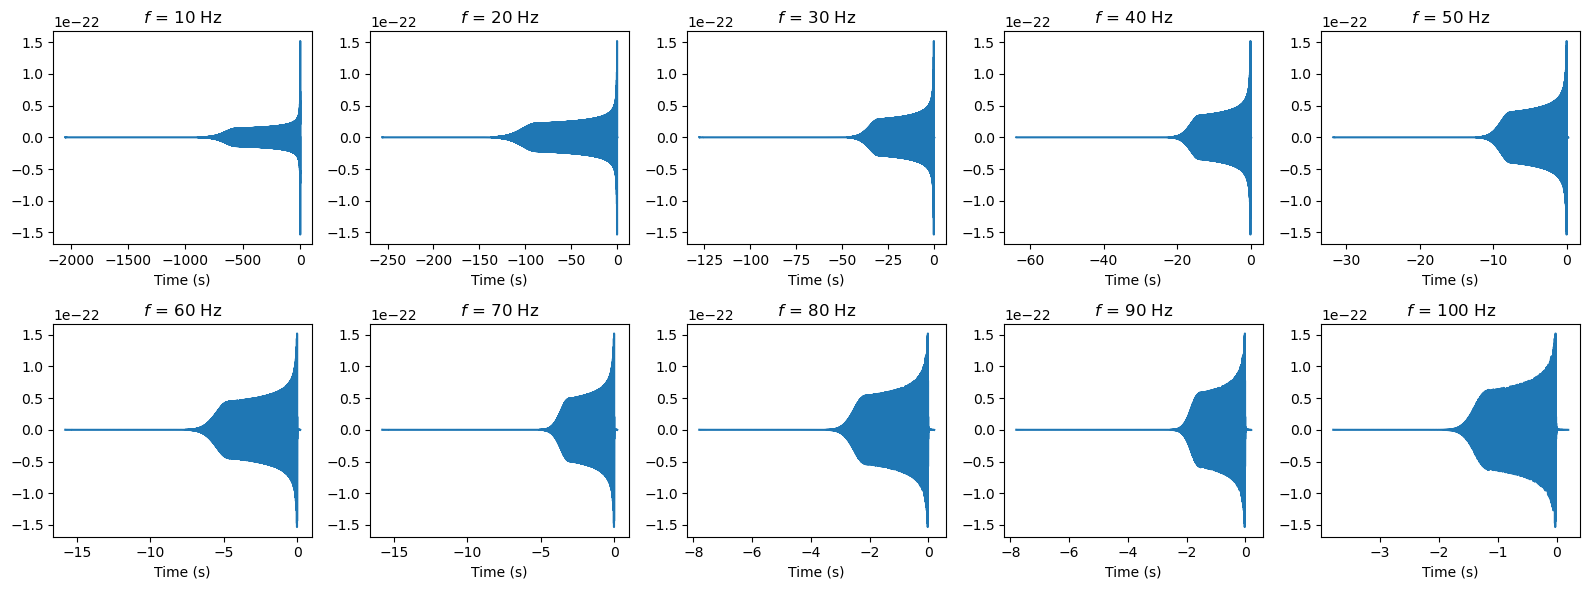

In [155]:
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
for ith_ax, ax in enumerate(axs.flatten()):
    ax.plot(hps[ith_ax].sample_times, hps[ith_ax])
    ax.set_title(f'$f$ = {freqs[ith_ax]:.0f} Hz')
    ax.set_xlabel('Time (s)')
fig.tight_layout()
plt.show()

In [127]:
len(hps[0]) / len(hps[9])

512.0

In [128]:
for idx, hp in enumerate(hps):
    print(f"Freq: {int(freqs[idx]):3}. Starting time: {hp.sample_times[0]:7}, end time: {hp.sample_times[-1]:.2f}")

Freq:  10. Starting time: -2047.8, end time: 0.20
Freq:  20. Starting time:  -255.8, end time: 0.20
Freq:  30. Starting time:  -127.8, end time: 0.20
Freq:  40. Starting time:   -63.8, end time: 0.20
Freq:  50. Starting time:   -31.8, end time: 0.20
Freq:  60. Starting time:   -15.8, end time: 0.20
Freq:  70. Starting time:   -15.8, end time: 0.20
Freq:  80. Starting time:    -7.8, end time: 0.20
Freq:  90. Starting time:    -7.8, end time: 0.20
Freq: 100. Starting time:    -3.8, end time: 0.20


Okay, we can see that the starting time varies with the `f_lower` parameter. If this is set to a lower value, the simulation starts earlier, yielding a longer duration.  
In all cases, simulations end 0.2 seconds after the merger.

**ALERT:** The behaviour I still do not understand is that the waveform "starts" (i.e. the amplitude becomes non-zero) at different times, depending on the frequency chosen.

In [ ]:
config['sample_rate'] = 1024 * 8

In [ ]:
freqs = np.linspace(50, 140, 10)
freqs

array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

In [ ]:
hps = []
for freq in freqs:
    config['freq_lower'] = freq
    hp, _ = gen_data_strain(config)
    hps.append(hp)

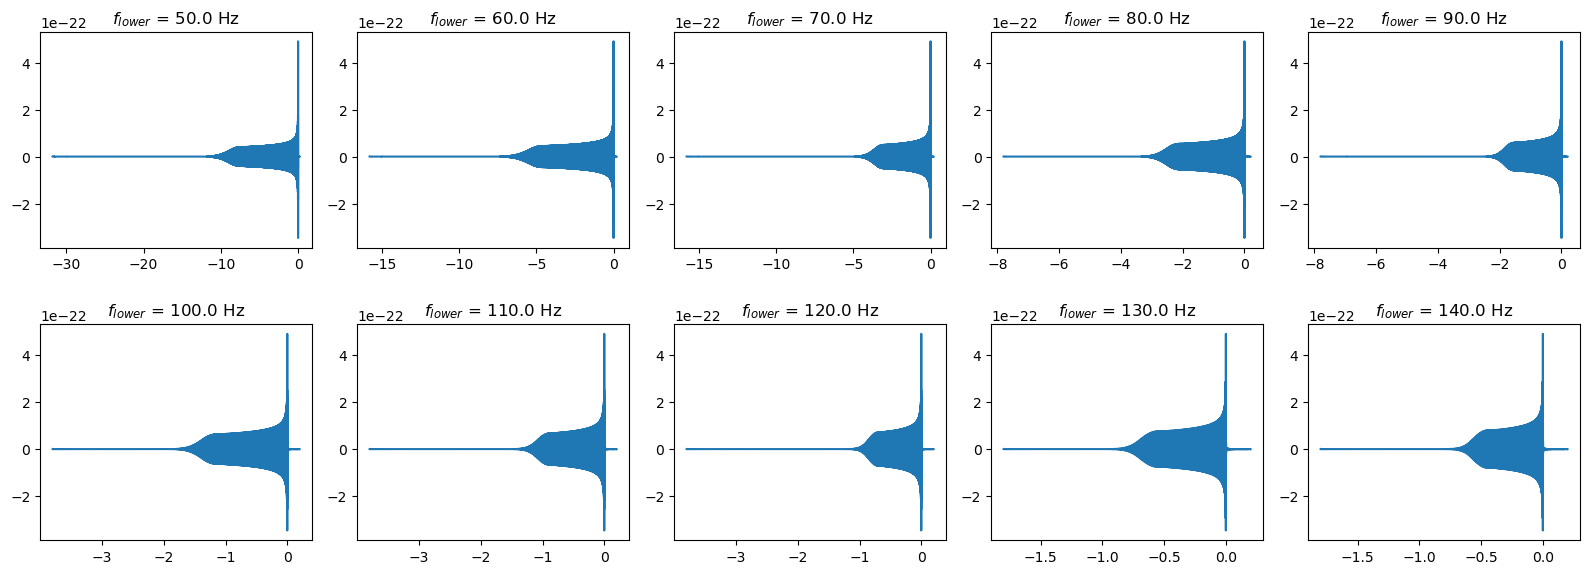

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
for ith_ax, ax in enumerate(axs.flatten()):
    ax.plot(hps[ith_ax].sample_times, hps[ith_ax])
    ax.set_title('$f_{lower}$' f' = {freqs[ith_ax]} Hz')
fig.tight_layout()
plt.show()

In [ ]:
len(hps[5])

32768

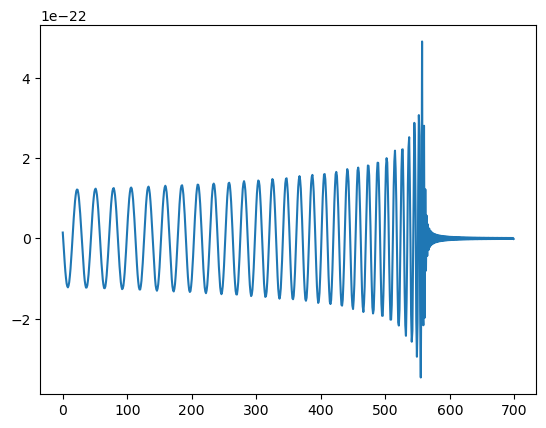

In [ ]:
plt.plot(np.array(hps[5])[-2200:-1500])

In [76]:
config['sample_rate'] = 1024 * 8

In [77]:
freqs = np.linspace(50, 140, 10)
freqs

array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

In [78]:
hps = []
for freq in freqs:
    config['freq_lower'] = freq
    hp, _ = gen_data_strain(config)
    hps.append(hp)

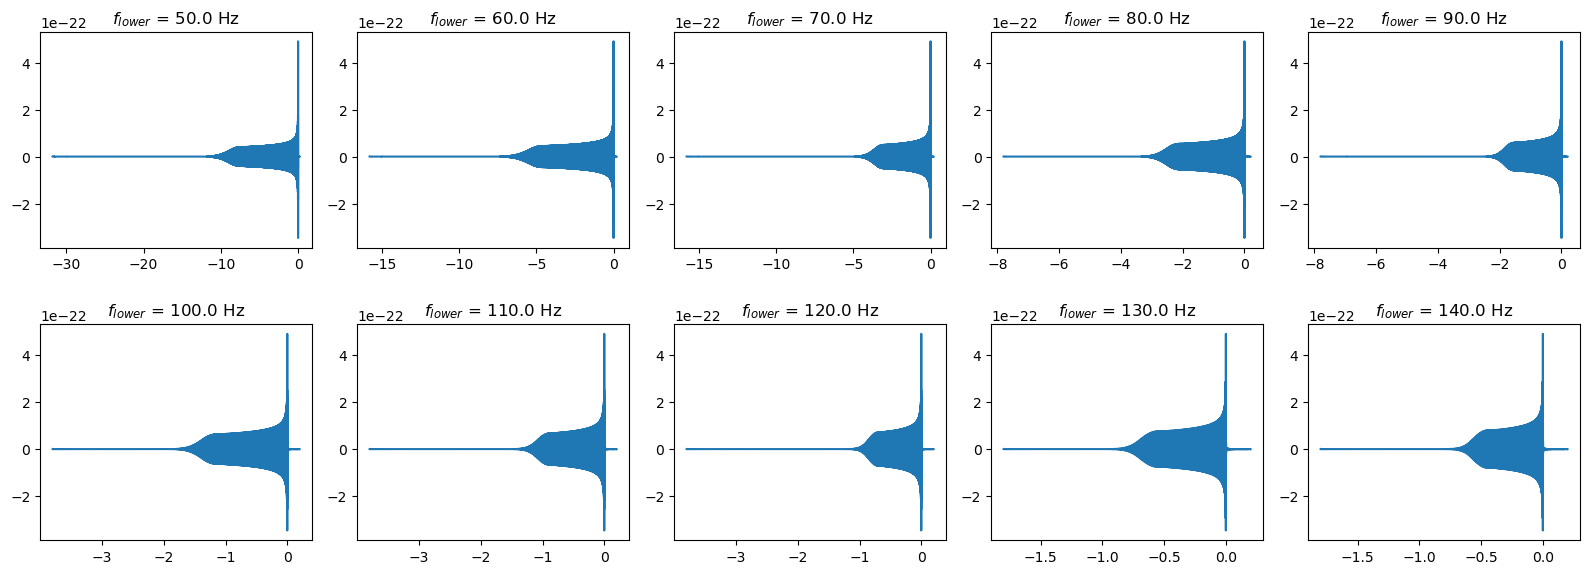

In [79]:
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
for ith_ax, ax in enumerate(axs.flatten()):
    ax.plot(hps[ith_ax].sample_times, hps[ith_ax])
    ax.set_title('$f_{lower}$' f' = {freqs[ith_ax]} Hz')
fig.tight_layout()
plt.show()

In [80]:
len(hps[5])

32768

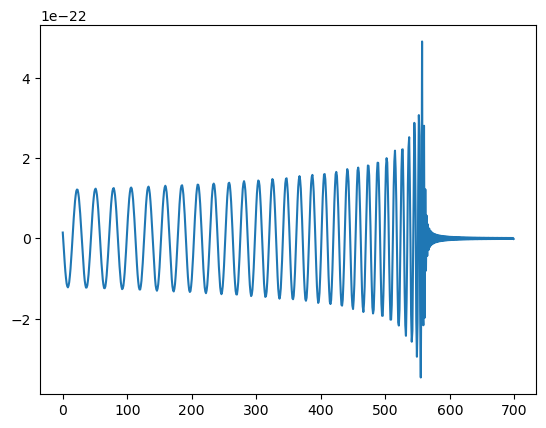

In [92]:
plt.plot(np.array(hps[5])[-2200:-1500])

In [93]:
config['sample_rate'] = 1024

In [94]:
freqs = np.linspace(50, 140, 10)
freqs

array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

In [95]:
hps = []
for freq in freqs:
    config['freq_lower'] = freq
    hp, _ = gen_data_strain(config)
    hps.append(hp)

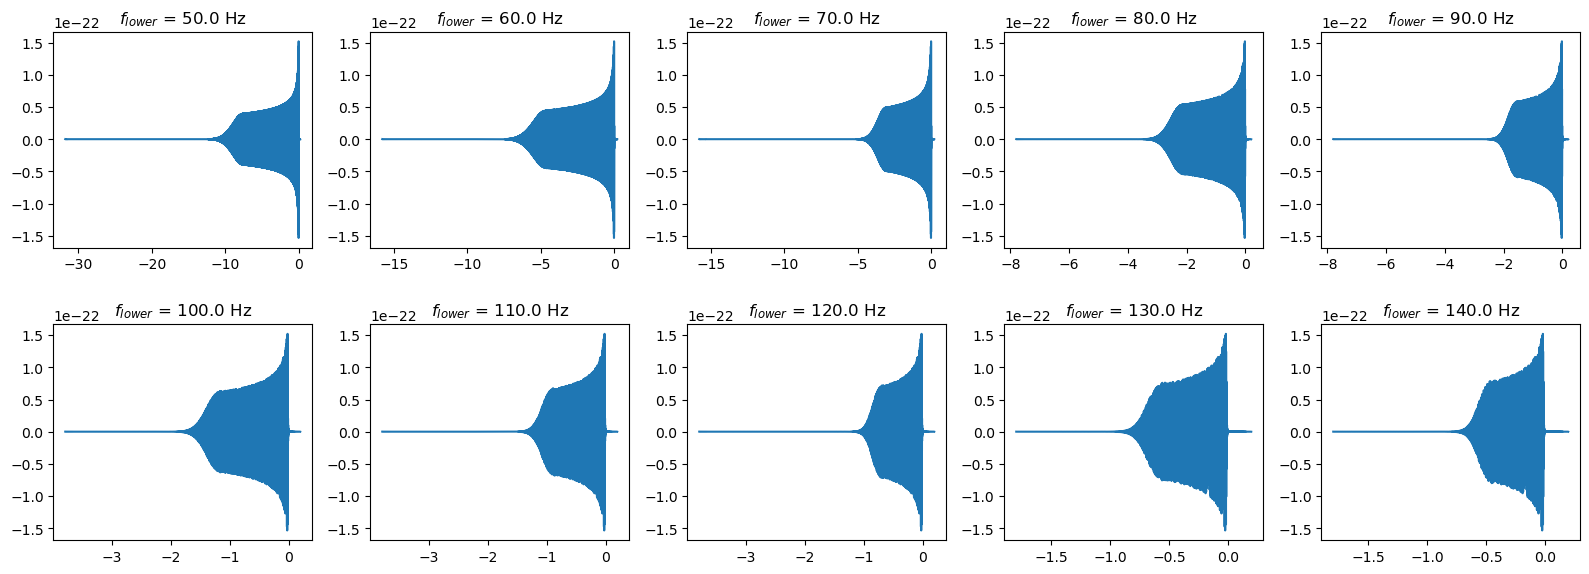

In [96]:
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
for ith_ax, ax in enumerate(axs.flatten()):
    ax.plot(hps[ith_ax].sample_times, hps[ith_ax])
    ax.set_title('$f_{lower}$' f' = {freqs[ith_ax]} Hz')
fig.tight_layout()
plt.show()

In [97]:
len(hps[5])

4096

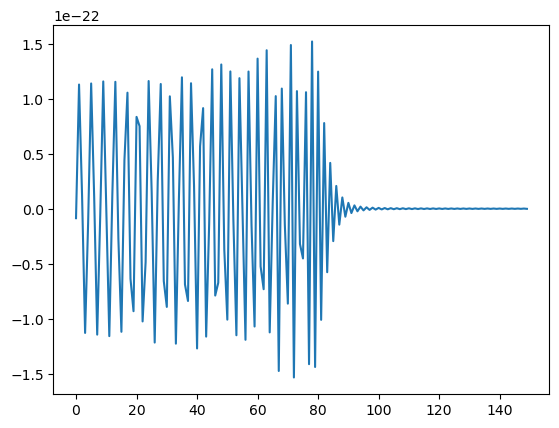

In [103]:
plt.plot(np.array(hps[5])[-300:-150])